In [1]:
# import laybrarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from plot_fig import *
from statsmodels.graphics.tsaplots import plot_pacf
simplefilter("ignore")


In [3]:
# read the orginal data from the csv file
df1 = pd.read_csv("well2.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2014-04-21', periods=717, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')
df.head()

,date,well_name,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,thp,tht,choke_size_percentage,QL,QG,well6_inj,well7_inj
0,2014-04-21,15/9-F-11,235.873938,106.375468,166.933556,11.407277,68.940382,66.720234,40.408819,1396.62,195812.61,0.0,0.0
1,2014-04-22,15/9-F-11,235.996225,106.379720,166.985180,11.345026,69.011045,66.374298,40.476998,1327.89,172837.67,0.0,0.0
2,2014-04-23,15/9-F-11,235.831538,106.386644,166.890508,11.429508,68.941031,65.144065,40.358610,1415.39,181708.34,0.0,0.0
3,2014-04-24,15/9-F-11,235.704145,106.396780,166.803572,6.683832,68.900574,65.062924,40.279861,916.84,119219.71,0.0,0.0
4,2014-04-25,15/9-F-11,235.913569,106.402976,166.910149,11.410404,69.003419,65.903653,40.384735,1446.17,184558.56,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   717 non-null    datetime64[ns]
 1   well_name              702 non-null    object        
 2   bhp                    702 non-null    float64       
 3   bht                    702 non-null    float64       
 4   dp_tubing              702 non-null    float64       
 5   AVG_CHOKE_SIZE_P       702 non-null    float64       
 6   thp                    702 non-null    float64       
 7   tht                    702 non-null    float64       
 8   choke_size_percentage  702 non-null    float64       
 9   QL                     702 non-null    float64       
 10  QG                     702 non-null    float64       
 11  well6_inj              702 non-null    float64       
 12  well7_inj              702 non-null    float64       
dtypes: da

In [5]:
df.isna().sum()

date                      0
well_name                15
bhp                      15
bht                      15
dp_tubing                15
AVG_CHOKE_SIZE_P         15
thp                      15
tht                      15
choke_size_percentage    15
QL                       15
QG                       15
well6_inj                15
well7_inj                15
dtype: int64

In [6]:
df = df.loc[:, [
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"
]]

df.head()

,date,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG
0,2014-04-21,235.873938,106.375468,166.933556,11.407277,195812.61
1,2014-04-22,235.996225,106.379720,166.985180,11.345026,172837.67
2,2014-04-23,235.831538,106.386644,166.890508,11.429508,181708.34
3,2014-04-24,235.704145,106.396780,166.803572,6.683832,119219.71
4,2014-04-25,235.913569,106.402976,166.910149,11.410404,184558.56


In [7]:
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df = df.dropna()

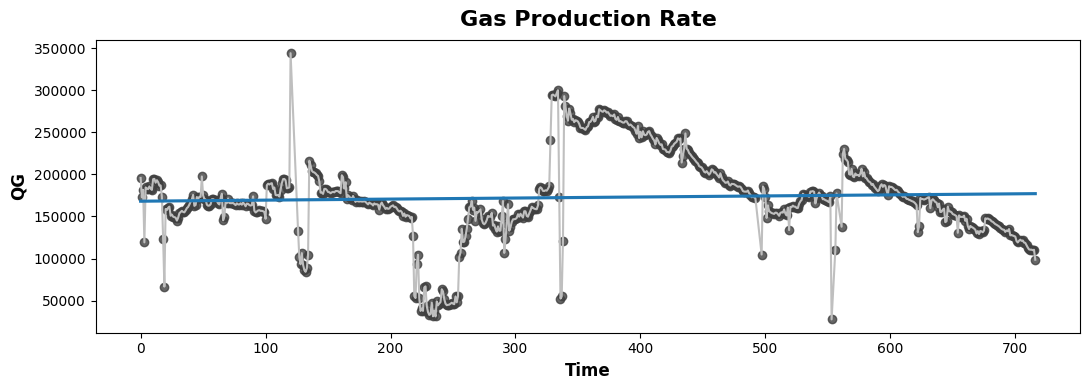

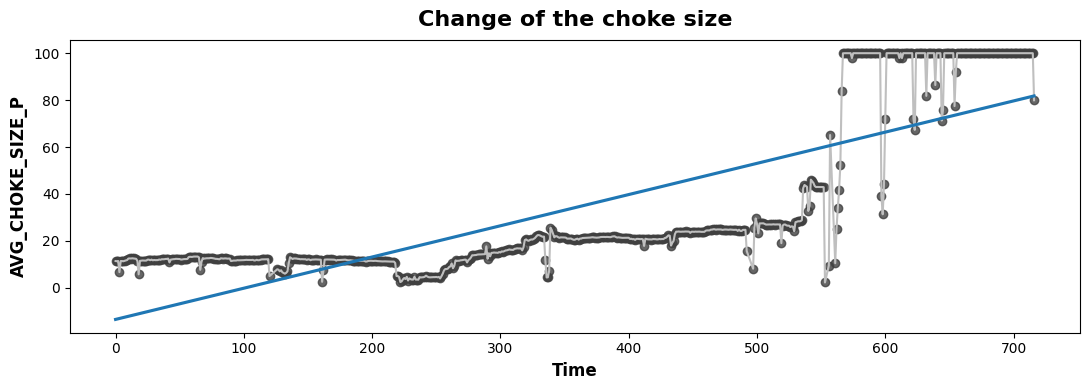

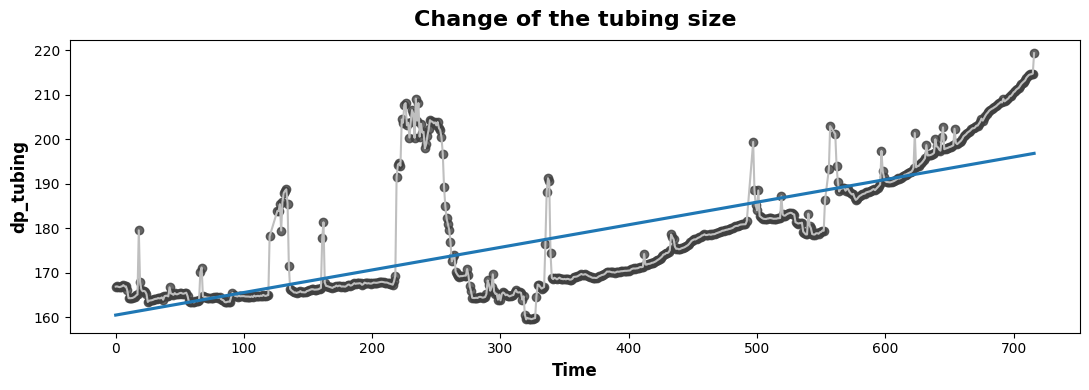

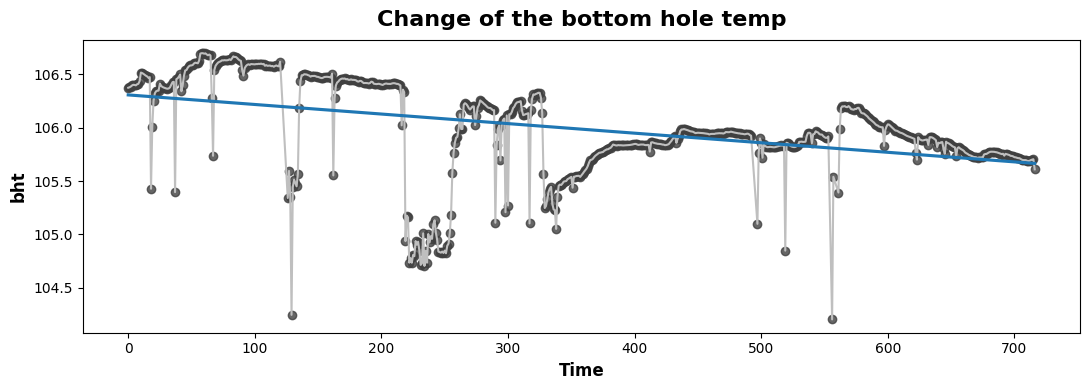

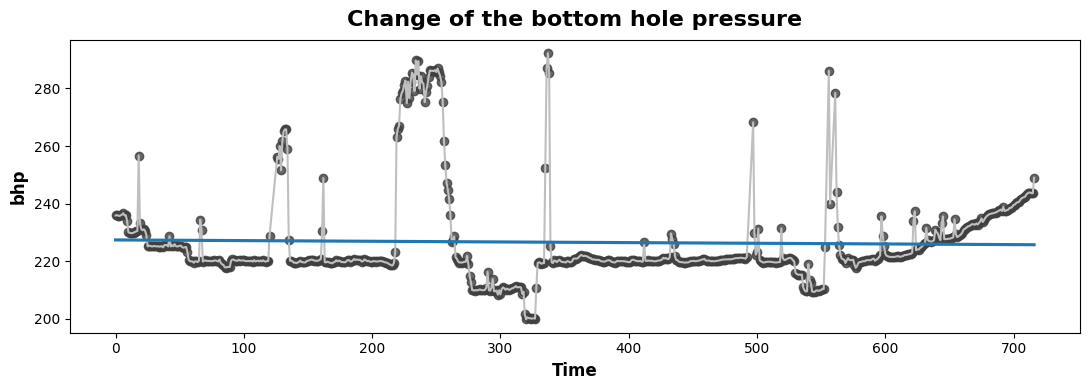

In [8]:
# Define a list of column names and their titles
plot_columns = [
    ('QG', 'Gas Production Rate'),
    ('AVG_CHOKE_SIZE_P', 'Change of the choke size'),
    ('dp_tubing', 'Change of the tubing size'),
    ('bht', 'Change of the bottom hole temp'),
    ('bhp', 'Change of the bottom hole pressure')
]

# Loop through each column and plot
for column, title in plot_columns:
    fig, ax = plt.subplots()
    ax.plot('Time', column, data=df, color='0.75')
    ax = sns.regplot(x='Time', y=column, data=df, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title(title)
    plt.show()

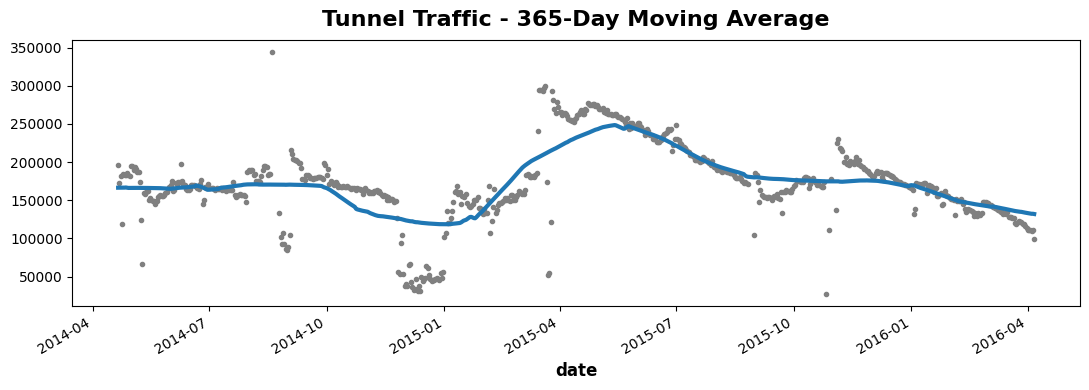

In [9]:
moving_average = df["QG"].rolling(
    window=120,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=30,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df["QG"].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [10]:
# add the lag
df["Lag_1"] = df["QG"].shift(1)
df.dropna(inplace=True)

In [11]:
X = df.copy()
y = X.pop("QG")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [12]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
# mi_scores[::3]  # show a few features with their MI scores
mi_scores

Lag_1               2.048446
Time                2.041951
dp_tubing           1.569986
bht                 1.536764
AVG_CHOKE_SIZE_P    1.072348
bhp                 0.958745
Name: MI Scores, dtype: float64

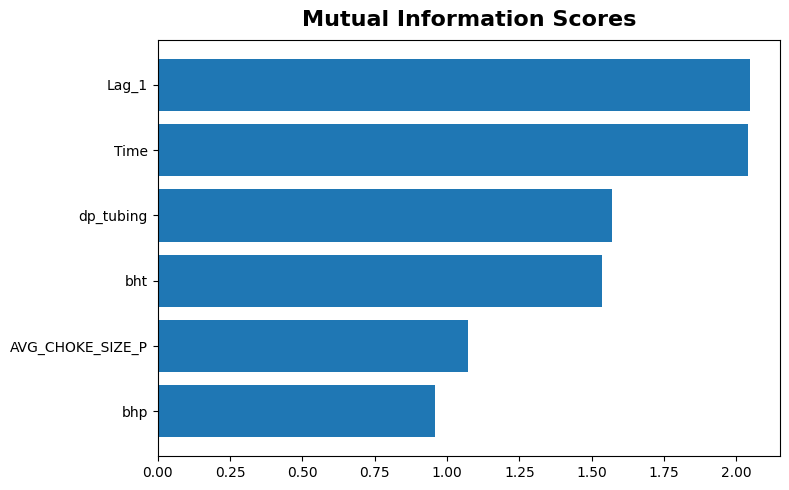

In [13]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [14]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time,Lag_1
bhp,1.000000,-0.656205,0.610257,-0.030971,-0.641432,-0.027604,-0.616583
bht,-0.656205,1.000000,-0.623006,-0.134601,0.261011,-0.423732,0.245461
dp_tubing,0.610257,-0.623006,1.000000,0.693050,-0.484839,0.721820,-0.473247
AVG_CHOKE_SIZE_P,-0.030971,-0.134601,0.693050,1.000000,-0.041676,0.807268,-0.045504
QG,-0.641432,0.261011,-0.484839,-0.041676,1.000000,0.052547,0.922891
Time,-0.027604,-0.423732,0.721820,0.807268,0.052547,1.000000,0.055192
Lag_1,-0.616583,0.245461,-0.473247,-0.045504,0.922891,0.055192,1.000000


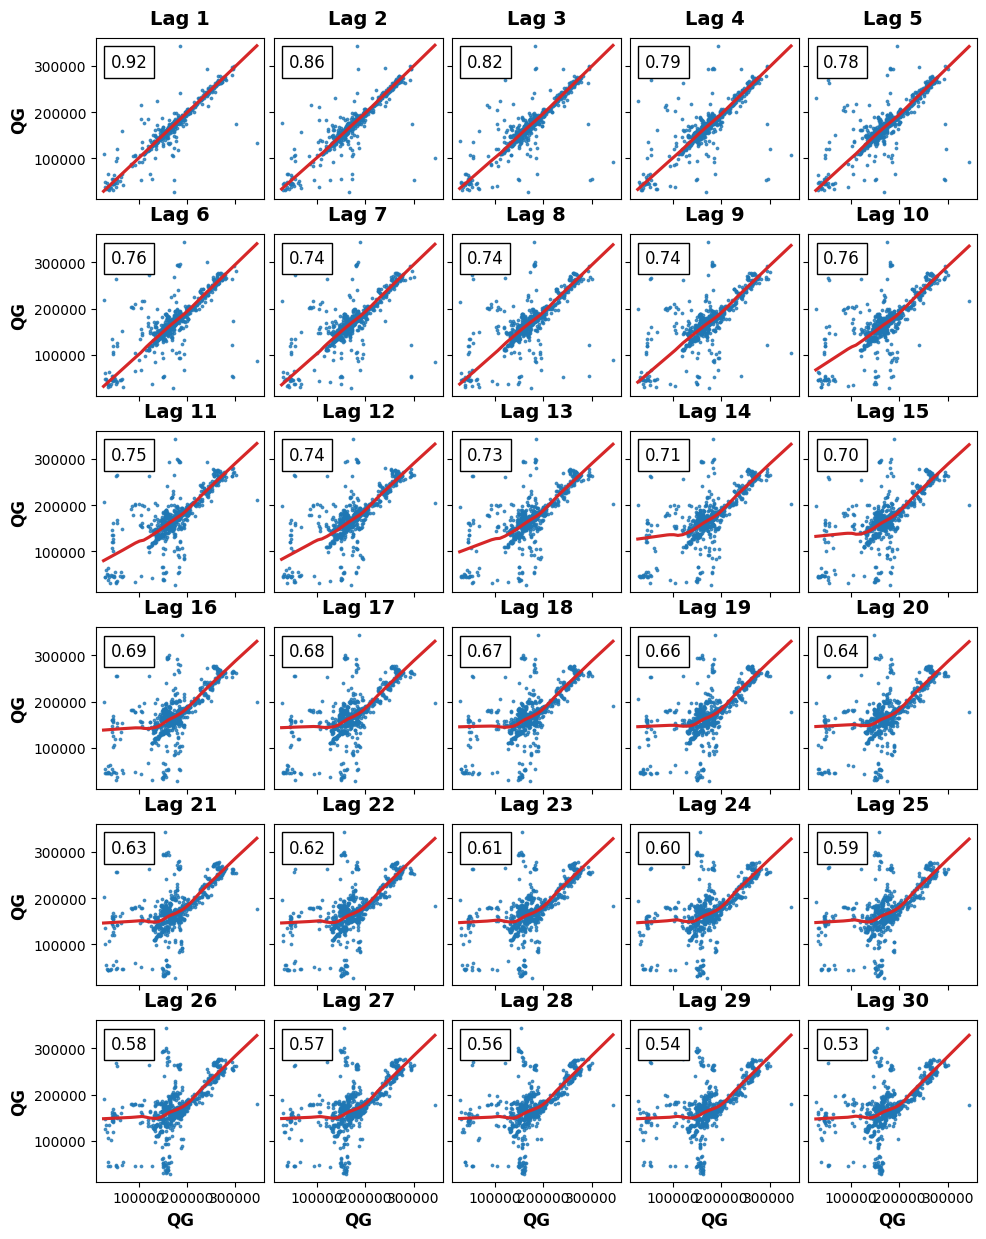

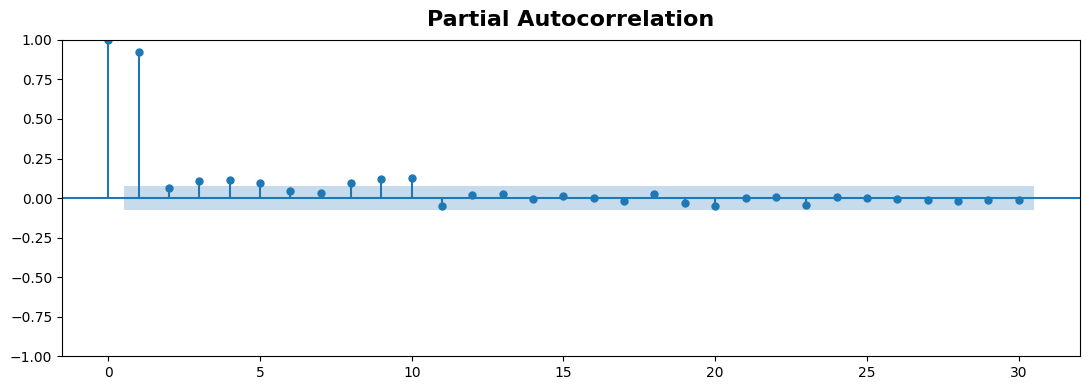

In [15]:
_ = plot_lags(df["QG"], lags=30, nrows=6)
_ = plot_pacf(df["QG"], lags=30)